In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llama-3.1/transformers/8b-instruct/1/model.safetensors.index.json
/kaggle/input/llama-3.1/transformers/8b-instruct/1/model-00003-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/1/config.json
/kaggle/input/llama-3.1/transformers/8b-instruct/1/model-00001-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/1/README.md
/kaggle/input/llama-3.1/transformers/8b-instruct/1/USE_POLICY.md
/kaggle/input/llama-3.1/transformers/8b-instruct/1/tokenizer.json
/kaggle/input/llama-3.1/transformers/8b-instruct/1/tokenizer_config.json
/kaggle/input/llama-3.1/transformers/8b-instruct/1/model-00004-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/1/special_tokens_map.json
/kaggle/input/llama-3.1/transformers/8b-instruct/1/model-00002-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/1/generation_config.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/model.safetensors.index.json
/kaggle/input/llama-3.1/tra

In [2]:
%%capture
%pip install -U bitsandbytes
%pip install -U transformers
%pip install -U accelerate
%pip install -U peft
%pip install -U trl

In [3]:
!pip install wandb
#!wandb login

417c27d3241951387db808a66a9d3316c434ec75

In [4]:
import wandb

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

wb_token = "417c27d3241951387db808a66a9d3316c434ec75"

wandb.login(key=wb_token)
run = wandb.init(
    project='Fine-tune llama-3.1-8b-it on Sentiment Analysis Dataset', 
    job_type="training", 
    anonymous="allow"
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cse-mahmud-evan (cse-mahmud-evan-ccn-university-of-science-and-technology). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.7
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240922_121518-2gh1i6cp
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run usual-puddle-23
wandb: ⭐️ View project at https://wandb.ai/cse-mahmud-evan-ccn-university-of-science-and-technology/Fine-tune%20llama-3.1-8b-it%20on%20Sentiment%20Analysis%20

In [5]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging
)
from sklearn.metrics import (

    accuracy_score,
    classification_report,
    confusion_matrix   
)
from sklearn.model_selection import train_test_split

In [6]:
data = pd.read_json('/kaggle/input/bangla-newspaper-dataset/data/data.json')
data.head()

,author,category,category_bn,published_date,modification_date,tag,comment_count,title,url,content
0,গাজীপুর প্রতিনিধি,bangladesh,বাংলাদেশ,"০৪ জুলাই ২০১৩, ২৩:২৬","০৪ জুলাই ২০১৩, ২৩:২৭",[গাজীপুর],0,"কালিয়াকৈরে টিফিন খেয়ে ৫০০ শ্রমিক অসুস্থ, বিক...",http://www.prothom-alo.com/bangladesh/article/...,গাজীপুরের কালিয়াকৈর উপজেলার তেলিরচালা এলাকায়...
1,অনলাইন ডেস্ক,sports,খেলা,"০৪ জুলাই ২০১৩, ২৩:০৯","০৪ জুলাই ২০১৩, ২৩:১১",[টেনিস],0,সেমিফাইনাল বাধাও পেরিয়ে গেলেন লিসিকি,http://www.prothom-alo.com/sports/article/19028,এবারের উইম্বলডনটা স্মরণীয় করে রাখার মিশনেই যে...
2,নিজস্ব প্রতিবেদক,bangladesh,বাংলাদেশ,"০৪ জুলাই ২০১৩, ২২:২৫","০৪ জুলাই ২০১৩, ২৩:১২",[রাজনীতি],0,সংসদে খালেদার অভিযোগের জবাব দিয়েছে ভারত,http://www.prothom-alo.com/bangladesh/article/...,জাতীয় সংসদে বিএনপি চেয়ারপারসন ও বিরোধীদলীয় ...
3,অনলাইন ডেস্ক,technology,বিজ্ঞান ও প্রযুক্তি,"০৪ জুলাই ২০১৩, ২১:৩৭","০৪ জুলাই ২০১৩, ২১:৪৫",[গবেষণা],0,পাসওয়ার্ড ভুলে যান!,http://www.prothom-alo.com/technology/article/...,সহজ পাসওয়ার্ডের কারণে অনলাইন অ্যাকাউন্ট সহজেই...
4,অনলাইন ডেস্ক,technology,বিজ্ঞান ও প্রযুক্তি,"০৪ জুলাই ২০১৩, ২১:৩৫","০৪ জুলাই ২০১৩, ২১:৩৭",[কম্পিউটার],0,চলে গেলেন মাউস উদ্ভাবক,http://www.prothom-alo.com/technology/article/...,কম্পিউটার মাউসের উদ্ভাবক ডগলাস অ্যাঙ্গেলবার্ট ...


In [7]:
len(data.columns)

10

In [8]:
ndf = data[['content','category']]

In [9]:
ndf.shape

(437948, 2)

In [10]:
ndf.duplicated().sum()

1793

In [11]:
ndf.drop_duplicates(inplace= True)

/tmp/ipykernel_23/3272145479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf.drop_duplicates(inplace= True)


In [12]:
ndf.shape

(436155, 2)

In [13]:
ndf.category.unique()

array(['bangladesh', 'sports', 'technology', 'entertainment',
       'international', 'economy', 'life-style', 'opinion', 'education',
       'we-are', 'onnoalo', 'pachmisheli', 'AskEditor', 'roshalo', '-1',
       'durporobash', 'facebook', 'events', 'kishoralo',
       'special-supplement', '22221', 'demo-content', 'trust',
       'northamerica', 'protichinta', 'bondhushava', 'bs-events',
       'mpaward1', 'diverse', 'tarunno', 'chakri-bakri', 'nagorik-kantho'],
      dtype=object)

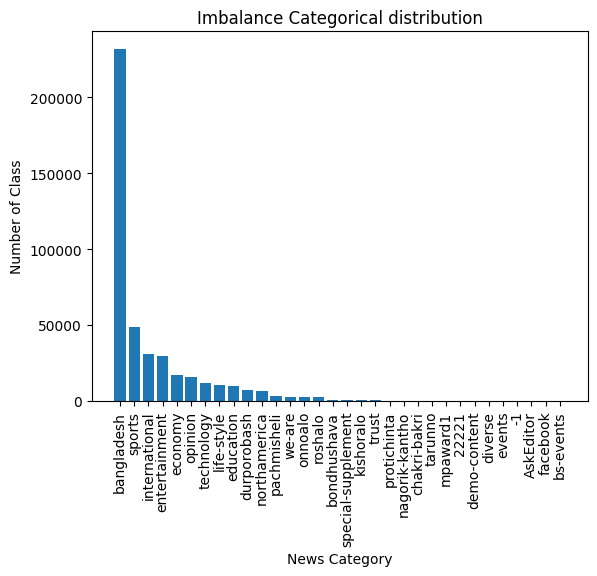

In [14]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt



labels = ndf['category'].value_counts().index
values = ndf['category'].value_counts().values

plt.bar(labels,values)
plt.title("Imbalance Categorical distribution")
plt.xticks(rotation=90)
plt.xlabel('News Category')
plt.ylabel('Number of Class')



plt.show()

In [15]:
'''from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
ndf['category'] = lbl.fit_transform(ndf['category'])'''

"from sklearn.preprocessing import LabelEncoder\nlbl = LabelEncoder()\nndf['category'] = lbl.fit_transform(ndf['category'])"

In [16]:
ndf.head()

,content,category
0,গাজীপুরের কালিয়াকৈর উপজেলার তেলিরচালা এলাকায়...,bangladesh
1,এবারের উইম্বলডনটা স্মরণীয় করে রাখার মিশনেই যে...,sports
2,জাতীয় সংসদে বিএনপি চেয়ারপারসন ও বিরোধীদলীয় ...,bangladesh
3,সহজ পাসওয়ার্ডের কারণে অনলাইন অ্যাকাউন্ট সহজেই...,technology
4,কম্পিউটার মাউসের উদ্ভাবক ডগলাস অ্যাঙ্গেলবার্ট ...,technology


In [17]:
train, test = train_test_split(ndf, test_size=0.3)
val, test = train_test_split(test, test_size=0.5)

In [18]:
train.head()

,content,category
12454,চট্টগ্রাম নগরের চট্টগ্রাম রপ্তানি প্রক্রিয়াজা...,bangladesh
225028,চলতি ২০১৫-১৬ অর্থবছর শেষে বাংলাদেশের মোট দেশজ ...,economy
105437,মেঘনার তলদেশ থেকে অবৈধভাবে বালু তুলছেন নারায়ণ...,bangladesh
166878,কিশোরগঞ্জের ভৈরবে সবুজ মিয়া (২৬) নামের এক ব্যব...,bangladesh
399089,জার্মানির কেমনিজ শহরে ‘ইউ আর মোর’ শীর্ষক বর্ণব...,international


In [19]:
ndf = ndf.sample(frac= 1, random_state = 48).reset_index(drop=True).head(1000)
ndf.head()

,content,category
0,চলতি অর্থবছরে বাংলাদেশের অর্থনীতি তুলনামূলকভাব...,economy
1,মুক্তিযুদ্ধে শহীদদের সংখ্যা নিয়ে বিতর্কিত মন্ত...,bangladesh
2,চট্টগ্রামের আনোয়ারা বিশ্ববিদ্যালয় কলেজ ছাত্রলী...,bangladesh
3,মনের মাধুরী দিয়ে অন্যকে সাজিয়ে তোলেন তাঁরা। ...,life-style
4,চট্টগ্রামের সীতাকুণ্ড উপজেলায় র‌্যাপিড অ্যাকশন...,bangladesh


In [20]:
train_size = 0.8
val_size = 0.1

train_end = int(train_size * len(ndf)) 
val_end = train_end + int(val_size * len(ndf))


In [21]:
X_train = ndf[:train_end]
X_val = ndf[train_end:val_end]
X_test = ndf[val_end:]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(800, 2)
(100, 2)
(100, 2)


In [22]:
# Define the prompt generation functions
def generate_prompt(data_point):
    return f"""
            Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.
text: {data_point["content"]}
label: {data_point["category"]}""".strip()

def generate_test_prompt(data_point):
    return f"""
            Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.
text: {data_point["content"]}
label: """.strip()

In [23]:
X_train.loc[:,'text'] = X_train.apply(generate_prompt,axis = 1)
X_train.head()

/tmp/ipykernel_23/605730108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,'text'] = X_train.apply(generate_prompt,axis = 1)


,content,category,text
0,চলতি অর্থবছরে বাংলাদেশের অর্থনীতি তুলনামূলকভাব...,economy,"Classify the text into bangladesh, sports, tec..."
1,মুক্তিযুদ্ধে শহীদদের সংখ্যা নিয়ে বিতর্কিত মন্ত...,bangladesh,"Classify the text into bangladesh, sports, tec..."
2,চট্টগ্রামের আনোয়ারা বিশ্ববিদ্যালয় কলেজ ছাত্রলী...,bangladesh,"Classify the text into bangladesh, sports, tec..."
3,মনের মাধুরী দিয়ে অন্যকে সাজিয়ে তোলেন তাঁরা। ...,life-style,"Classify the text into bangladesh, sports, tec..."
4,চট্টগ্রামের সীতাকুণ্ড উপজেলায় র‌্যাপিড অ্যাকশন...,bangladesh,"Classify the text into bangladesh, sports, tec..."


In [24]:
X_val.loc[:,'text'] = X_val.apply(generate_prompt, axis=1)
X_val.head()

/tmp/ipykernel_23/1181508762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.loc[:,'text'] = X_val.apply(generate_prompt, axis=1)


,content,category,text
800,বিএনপির জাতীয় স্থায়ী কমিটির সদস্য মওদুদ আহমদ ব...,bangladesh,"Classify the text into bangladesh, sports, tec..."
801,রাজ্যসভার সদস্যপদ ছেড়ে দিয়ে সাবেক দল তৃণমূল কং...,international,"Classify the text into bangladesh, sports, tec..."
802,গে্যটে ইনস্টিটিউট মিলনায়তনে গতকাল অস্ট্রেলিয়ান...,entertainment,"Classify the text into bangladesh, sports, tec..."
803,আসন্ন পৌর নির্বাচনে ভোটের দিন মানুষ ‘জান লড়ি...,bangladesh,"Classify the text into bangladesh, sports, tec..."
804,প্রধানমন্ত্রী শেখ হাসিনা বিএনপি-জামায়াত জোটের ...,bangladesh,"Classify the text into bangladesh, sports, tec..."


In [25]:
X_test.head()

,content,category
900,১৯৭১ সালের ২৫ মার্চ মধ্যরাতের পর পাকিস্তানি শা...,bangladesh
901,সুন্দরবন থেকে শিকার করে আনা হরিণের চারটি মাথাস...,bangladesh
902,বরিশাল-ভোলা-চট্টগ্রাম মহাসড়কে ভোলা সদর উপজেল...,bangladesh
903,আর তো কয়েক ঘণ্টা! এর পরই সেন্ট ভিনসেন্টের আর্...,sports
904,তথ্য ও বিনোদনমেনটস বাত্তি জ্বালাওআসিফ এন্তাজ ...,entertainment


In [26]:
y_true = X_test.loc[:,'category']
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis = 1), columns = ['text'])

In [27]:
X_test.head()

,text
900,"Classify the text into bangladesh, sports, tec..."
901,"Classify the text into bangladesh, sports, tec..."
902,"Classify the text into bangladesh, sports, tec..."
903,"Classify the text into bangladesh, sports, tec..."
904,"Classify the text into bangladesh, sports, tec..."


In [28]:
X_val.shape

(100, 3)

In [29]:
y_true.head()

900       bangladesh
901       bangladesh
902       bangladesh
903           sports
904    entertainment
Name: category, dtype: object

In [30]:
X_test.head()

,text
900,"Classify the text into bangladesh, sports, tec..."
901,"Classify the text into bangladesh, sports, tec..."
902,"Classify the text into bangladesh, sports, tec..."
903,"Classify the text into bangladesh, sports, tec..."
904,"Classify the text into bangladesh, sports, tec..."


In [31]:
X_train.category.value_counts()

category
bangladesh       404
sports            91
international     66
entertainment     66
economy           38
technology        29
opinion           24
life-style        20
education         17
durporobash       12
northamerica       8
roshalo            8
we-are             7
onnoalo            4
pachmisheli        3
bondhushava        2
trust              1
Name: count, dtype: int64

In [32]:
y_true.value_counts()

category
bangladesh       43
sports           21
entertainment    11
international     8
economy           6
life-style        4
opinion           3
northamerica      2
technology        1
roshalo           1
Name: count, dtype: int64

In [33]:
from datasets import Dataset
# Convert to datasets
train_data = Dataset.from_pandas(X_train[["text"]])
val_data = Dataset.from_pandas(X_val[["text"]])

In [34]:
print(train_data)
print(val_data)

Dataset({
    features: ['text'],
    num_rows: 800
})
Dataset({
    features: ['text'],
    num_rows: 100
})


In [35]:
train_data['text'][3]

'Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.\ntext: মনের মাধুরী দিয়ে অন্যকে সাজিয়ে তোলেন তাঁরা। তাঁদের হাতের সুনিপুণ ছোঁয়ায় আজকের বিয়ের কনে হয়ে ওঠেন অপরূপা। একদিন তাঁদের জীবনেও এসেছিল সেই দিন। সেদিন কেমন সেজেছিলেন তাঁরা? নিজেদের বিয়ের সাজের সেই অনুভূতি নিয়ে বলেছেন তিনজন রূপবিশেষজ্ঞ—গীতি’স বিউটি পারলার অ্যান্ড ট্রেনিং সেন্টারের গীতি বিল্লাহ, পারসোনার কানিজ আলমাস খান এবং ফেমিনা বিউটি পারলার অ্যান্ড হারবাল স্কিন কেয়ারের অঞ্জলী মোস্তফা সাতজন মিলে বেটেছিলেন মেহেদি পাতাগীতি বিল্লাহনতুন বউকে আলাদা করে চেনা যায় তার মেহেদিরাঙা হাতের চুড়ির রিনিঝিনিতে। কনের হাতে মেহেদির নকশা যেন চুপিচুপি কনের মনের কথাই জানান দেয়। আমাদের সময়ে টিউব মেহেদি না থাকাটাই বরং ভালো ছিল। সবাই মিলে দল বেঁধে মেহেদি পাতা তুলতে যাওয়ার মধ্যে একটা আনন্দ ছিল। নিজের বিয়ের সময় কনে পদাধিকার বলে সেই আনন্দ থেকে আমাকে বঞ্চিত করা হয়েছিল। আমার বিয়ের সে মেহেদি পাতা বেটেছিলেন 

In [36]:
base_model_name = '/kaggle/input/llama-3.1/transformers/8b-instruct/1'

bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_use_double_quant = False,
    bnb_4bit_quant_type = 'nf4',
    llm_int8_enable_fp32_cpu_offload=True,
    bnb_4bit_compute_dtype = 'float16')


model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    quantization_config=bnb_config, 
)

model.config._use_cache = False
model.config.pretaining_tp = 1

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [37]:
'''input_ids = input_ids.to(torch.float16)
attention_mask = attention_mask.to(torch.float16)'''

'input_ids = input_ids.to(torch.float16)\nattention_mask = attention_mask.to(torch.float16)'

In [38]:
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token_id  = tokenizer.eos_token_id

In [39]:
'''model = model.to(torch.float16)'''

'model = model.to(torch.float16)'

In [40]:
def predict(test,model,tokenizer):
    y_pred = []
    categories = ['bangladesh', 'sports', 'technology', 'entertainment',
       'international', 'economy', 'life-style', 'opinion', 'education']


    
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        max_new_tokens=2, 
                        temperature=0.1,
                        torch_dtype=torch.float16)
        
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("label:")[-1].strip()
        
        # Determine the predicted category
        for category in categories:
            if category.lower() in answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")
    
    return y_pred

In [41]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 100/100 [09:13<00:00,  5.54s/it]


In [42]:
def evaluate(y_true, y_pred):
    labels = ['bangladesh', 'sports', 'technology', 'entertainment',
       'international', 'economy', 'life-style', 'opinion', 'education']
    mapping = {label: idx for idx, label in enumerate(labels)}
    
    def map_func(x):
        return mapping.get(x, -1)  # Map to -1 if not found, but should not occur with correct data
    
    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = set(y_true_mapped)  # Get unique labels
    
    for label in unique_labels:
        label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
        label_y_true = [y_true_mapped[i] for i in label_indices]
        label_y_pred = [y_pred_mapped[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {labels[label]}: {label_accuracy:.3f}')
        
    # Generate classification report
    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))))
    print('\nClassification Report:')
    print(class_report)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

In [43]:
evaluate(y_true, y_pred)

Accuracy: 0.490
Accuracy for label bangladesh: 0.605
Accuracy for label sports: 0.476
Accuracy for label technology: 1.000
Accuracy for label entertainment: 0.091
Accuracy for label international: 0.500
Accuracy for label economy: 0.500
Accuracy for label life-style: 1.000
Accuracy for label opinion: 0.000
Accuracy for label education: 0.000

Classification Report:
               precision    recall  f1-score   support

   bangladesh       0.59      0.60      0.60        43
       sports       1.00      0.48      0.65        21
   technology       1.00      1.00      1.00         1
entertainment       1.00      0.09      0.17        11
international       0.40      0.50      0.44         8
      economy       0.75      0.50      0.60         6
   life-style       0.29      1.00      0.44         4
      opinion       0.00      0.00      0.00         3
    education       0.00      0.00      0.00         0

    micro avg       0.53      0.51      0.52        97
    macro avg       0.56 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:  # needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [45]:
modules = find_all_linear_names(model)
modules

['gate_proj', 'v_proj', 'up_proj', 'k_proj', 'down_proj', 'q_proj', 'o_proj']

In [46]:
output_dir="llama-3.1 8b model"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=1,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    logging_steps=1,                         
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=False,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    report_to="wandb",                  # report metrics to w&b
    eval_strategy="steps",              # save checkpoint every epoch
    eval_steps = 0.2
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=val_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=256,
    packing=False,
    dataset_kwargs={
    "add_special_tokens": False,
    "append_concat_token": False,
    }
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length, dataset_kwargs. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:327: UserWarning: You passed a `dataset_kwargs` argument to the SFTTrainer, the value you pass

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [47]:
# Train model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), d

Step,Training Loss,Validation Loss
20,0.687700,0.677686
40,0.669100,0.657576
60,0.631100,0.649097
80,0.691800,0.643430
100,0.663400,0.642030


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


TrainOutput(global_step=100, training_loss=0.7255406033992767, metrics={'train_runtime': 2243.4507, 'train_samples_per_second': 0.357, 'train_steps_per_second': 0.045, 'total_flos': 9271372265398272.0, 'train_loss': 0.7255406033992767, 'epoch': 1.0})

In [48]:
wandb.finish()
model.config.use_cache = True

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               eval/loss █▄▂▁▁
wandb:            eval/runtime █▂▆▁▇
wandb: eval/samples_per_second ▁▁▁▁▁
wandb:   eval/steps_per_second ▁▁▁▁▁
wandb:             train/epoch ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:       train/global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:         train/grad_norm ▂▁▂█▁▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     train/learning_rate ▃███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
wandb:              train/loss █▇▅▃▃▃▂▂▂▂▃▂▂▁▁▃▁▂▃▂▂▂▁▁▂▁▂▂▁▃▁▂▁▂▂▁▂▂▂▂
wandb: 
wandb: Run summary:
wandb:                eval/loss 0.64203
wandb:             eval/runtime 55.108
wandb:  eval/samples_per_second 1.815
wandb:    eval/steps_per_second 0.236
wandb:               total_flos 9271372265398272.0
wandb:              train/epoch 1.0
wandb:        train/global_step 100
wandb:          train/grad_norm 0.41933
wandb:      train/learning_rate

In [49]:
#Save Train Model and Tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('llama-3.1 8b model/tokenizer_config.json',
 'llama-3.1 8b model/special_tokens_map.json',
 'llama-3.1 8b model/tokenizer.json')

In [50]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 100/100 [09:44<00:00,  5.84s/it]


In [51]:
evaluate(y_true, y_pred)

Accuracy: 0.350
Accuracy for label bangladesh: 0.070
Accuracy for label sports: 0.762
Accuracy for label technology: 1.000
Accuracy for label entertainment: 0.818
Accuracy for label international: 0.000
Accuracy for label economy: 0.833
Accuracy for label life-style: 0.250
Accuracy for label opinion: 0.000
Accuracy for label education: 0.000

Classification Report:
               precision    recall  f1-score   support

   bangladesh       1.00      0.07      0.13        43
       sports       0.76      0.76      0.76        21
   technology       0.33      1.00      0.50         1
entertainment       0.38      0.82      0.51        11
international       0.00      0.00      0.00         8
      economy       0.14      0.83      0.24         6
   life-style       0.50      0.25      0.33         4
      opinion       0.00      0.00      0.00         3
    education       0.00      0.00      0.00         0

    micro avg       0.36      0.36      0.36        97
    macro avg       0.35 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

In [52]:
#X_val.head()

In [53]:
#vali = X_val.drop('category',axis = 1)

In [54]:
#vali.head(2)

In [55]:
'''import pandas as pd
import torch
import numpy as np


# Function to convert text to a byte representation
def text_to_bytes(text):
    return [float(byte) for byte in text.encode('utf-8')]

# Apply to each column
X_test['content_bytes'] = vali['content'].apply(text_to_bytes)
X_test['text_bytes'] = vali['text'].apply(text_to_bytes)

# Find the maximum length of the sequences
max_len_content = max(vali['content_bytes'].apply(len))
max_len_text = max(vali['text_bytes'].apply(len))

# Function to pad sequences
def pad_sequence(seq, max_len):
    return seq + [0.0] * (max_len - len(seq))

# Pad sequences
vali['content_bytes_padded'] = vali['content_bytes'].apply(lambda x: pad_sequence(x, max_len_content))
vali['text_bytes_padded'] = vali['text_bytes'].apply(lambda x: pad_sequence(x, max_len_text))

# Convert the padded lists of bytes to PyTorch tensors
content_tensor = torch.tensor(vali['content_bytes_padded'].tolist(), dtype=torch.float32)
text_tensor = torch.tensor(vali['text_bytes_padded'].tolist(), dtype=torch.float32)

# Convert to bfloat16
content_bfloat16 = content_tensor.to(torch.bfloat16)
text_bfloat16 = text_tensor.to(torch.bfloat16)

'''

"import pandas as pd\nimport torch\nimport numpy as np\n\n\n# Function to convert text to a byte representation\ndef text_to_bytes(text):\n    return [float(byte) for byte in text.encode('utf-8')]\n\n# Apply to each column\nX_test['content_bytes'] = vali['content'].apply(text_to_bytes)\nX_test['text_bytes'] = vali['text'].apply(text_to_bytes)\n\n# Find the maximum length of the sequences\nmax_len_content = max(vali['content_bytes'].apply(len))\nmax_len_text = max(vali['text_bytes'].apply(len))\n\n# Function to pad sequences\ndef pad_sequence(seq, max_len):\n    return seq + [0.0] * (max_len - len(seq))\n\n# Pad sequences\nvali['content_bytes_padded'] = vali['content_bytes'].apply(lambda x: pad_sequence(x, max_len_content))\nvali['text_bytes_padded'] = vali['text_bytes'].apply(lambda x: pad_sequence(x, max_len_text))\n\n# Convert the padded lists of bytes to PyTorch tensors\ncontent_tensor = torch.tensor(vali['content_bytes_padded'].tolist(), dtype=torch.float32)\ntext_tensor = torch.te

In [56]:
#vali.drop()

In [57]:
'''print(content_bfloat16)
print(text_bfloat16)'''

'print(content_bfloat16)\nprint(text_bfloat16)'